In [1]:
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.io import output_notebook
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

In [187]:
pal_df = pd.read_csv('../../data/nyiso_pal_master.csv')
isolf_df = pd.read_csv('../../data/nyiso_isolf_master.csv')
pal_df.head()

,Time Stamp,Name,PTID,min,max,mean
0,2011-04-01,N.Y.C.,61761,4327.3,6665.2,5804.383624
1,2011-04-02,N.Y.C.,61761,4320.8,5717.3,5142.040625
2,2011-04-03,N.Y.C.,61761,4181.5,5691.4,4982.166436
3,2011-04-04,N.Y.C.,61761,4144.2,6461.6,5643.067474
4,2011-04-05,N.Y.C.,61761,4143.5,6566.4,5682.628819


In [193]:
pal_df.rename(columns={'min': 'pal_min', 'max': 'pal_max', 'mean': 'pal_mean'}, inplace=True)
pal_df['Time Stamp'] = pd.to_datetime(pal_df['Time Stamp'])
pal_df.columns.tolist()

['Time Stamp', 'Name', 'PTID', 'pal_min', 'pal_max', 'pal_mean']

In [194]:
isolf_df.rename(columns={'min': 'isolf_min', 'max': 'isolf_max', 'mean': 'isolf_mean'}, inplace=True)
isolf_df['Time Stamp'] = pd.to_datetime(isolf_df['Time Stamp'])
isolf_df.columns.tolist()

['Time Stamp', 'isolf_min', 'isolf_max', 'isolf_mean', 'Name', 'PTID']

In [107]:
# We can merge our two datasets and add some nuance to our dates
df = pal_df.merge(isolf_df, sort=True)
df.drop(['PTID', 'Name'], axis='columns', inplace=True)
df['weekday'] = df['Time Stamp'].dt.weekday
df['week'] = df['Time Stamp'].dt.week
df['month'] = df['Time Stamp'].dt.month
df['year'] = df['Time Stamp'].dt.year
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5514 entries, 0 to 5513
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Time Stamp  5514 non-null   datetime64[ns]
 1   pal_min     5514 non-null   float64       
 2   pal_max     5514 non-null   float64       
 3   pal_mean    5514 non-null   float64       
 4   isolf_min   5514 non-null   float64       
 5   isolf_max   5514 non-null   float64       
 6   isolf_mean  5514 non-null   float64       
 7   weekday     5514 non-null   int64         
 8   week        5514 non-null   int64         
 9   month       5514 non-null   int64         
 10  year        5514 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 516.9 KB


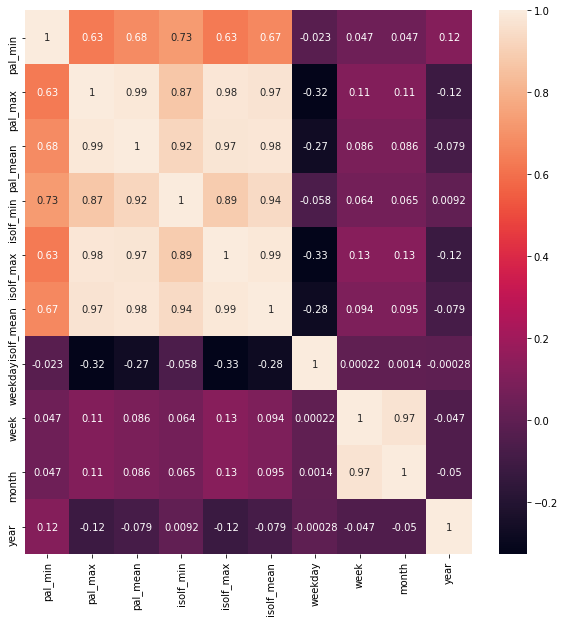

In [115]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=corr, ax=ax, annot=True)

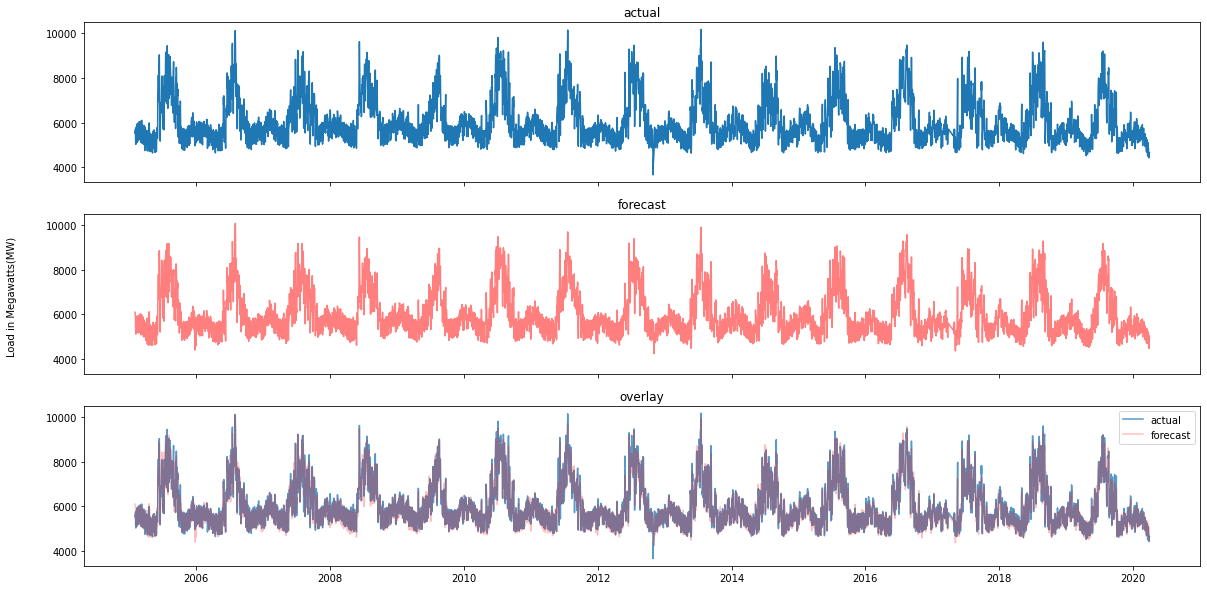

In [196]:
fig, axes = plt.subplots(3, 1, figsize=(20,10), sharex=True, sharey=True)
axes[0].plot(df['Time Stamp'], df['pal_mean'])
axes[0].set_title('actual')
axes[1].plot(df['Time Stamp'], df['isolf_mean'], c='red', alpha=.5)
axes[1].set_title('forecast')
axes[2].plot(df['Time Stamp'], df['pal_mean'], label='actual', alpha=.75, ms=.5)
axes[2].plot(df['Time Stamp'], df['isolf_mean'], c='red', alpha=.25, label='forecast', ms=.5)
axes[2].set_title('overlay')
axes[2].legend()
fig.text(.075, .5, 'Load in Megawatts(MW)', ha='center', va='center', rotation='vertical')
plt.show()

#Lots of overlap! Means the ISO has done a good job forecasting so far.
# But outside of the seasonal cycles, we don't see a pronounced drop or increase over time. We can assume 
# probably assume relatively stability for now

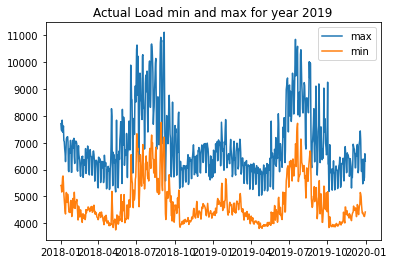

In [141]:
# Let's check out the regularity of our load data
mask = (df['Time Stamp'] > datetime.datetime(2018, 1, 1)) & (df['Time Stamp'] < datetime.datetime(2020, 1, 1))
plt.plot(df.loc[mask]['Time Stamp'], df.loc[mask]['pal_max'], ms=.5, label='max')
plt.plot(df.loc[mask]['Time Stamp'], df.loc[mask]['pal_min'], ms=.5, label='min')
plt.title('Actual Load min and max for 2018 and 2019')
plt.legend()
plt.show()

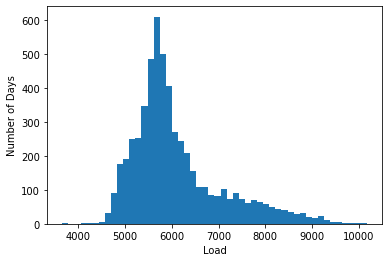

In [101]:
# Finally, let's check out the frequency of our load in histogram form
fig, ax = plt.subplots()
ax.set_xlabel('Load (MW)')
ax.set_ylabel('Number of Days')
ax.hist(df['pal_mean'], 50)
plt.show()

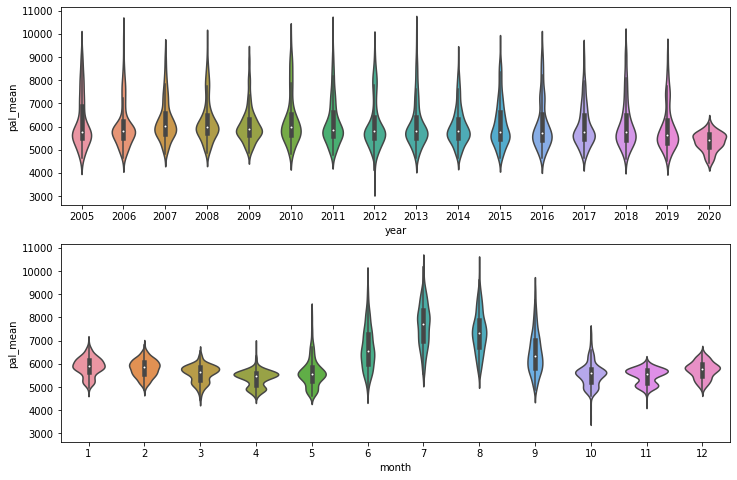

In [179]:
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharey=True)
sns.violinplot(df['year'], df['pal_mean'], ax=ax[0])
sns.violinplot(df['month'], df['pal_mean'], ax=ax[1])
plt.show()

# Here again we can see our distribution play out across multiple years settling between around our mean at 5.5k
# We can also see that most of the variation (our tails) can be accounted for in the summer months

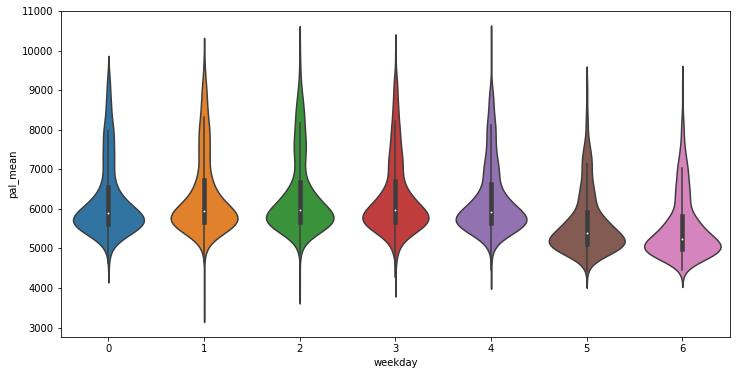

In [186]:
 # We also notice that weekday has some correlation to our load value. Let's check it out further

fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(df['weekday'], df['pal_mean'])
plt.show()

# Wonderful! We see that the weekends (weekday 5 and 6) are shaped similar, but have a lower center.
# We can also assume that our season variation discovered above could be found by following the month vector